# Introdução

A AmBev é uma companhia brasileira de capital aberto, focada no ramo de bebidas, principalmente cervejas. Nascida da fusão entre a Companhia Antarctica Paulista de São Paulo e a Companhia Cervejaria Brahma do Rio de Janeiro, hoje domina boa parte do mercado brasileiro e mundial, sendo detentora de um grande número de marcas nos segmentos onde atua.

Neste desafio, recebemos dados relacionados às metas estabelecidas pela empresa. Pelo que podemos observar, a empresa tem implantado um sistema de KPIs (do inglês, *Key Performance Indicator*, ou Indicador-chave de performance). Neste sistema, a cada funcionário são atribuídas metas, dentro das atividades a serem desenvolvidas por ele, e cada uma delas possui um peso, de acordo com sua relevância. O acompanhamento é feito mensalmente, com o registro de pontos, representando o quão próximo o funcionário está de cumprir aquela meta.

Como parte do desafio, deve-se fazer uma análise dos dados, com foco em business; e criar um modelo capaz de prever o percentual de cumprimento da meta ao fim do ano para um determinado funcionário. 

## Atalhos
Fornecemos aqui alguns atalhos para facilitar a navegação no notebook.

- [Leitura/Limpeza dos dados](#Leitura/Limpeza-dos-dados)
- [Exploração dos Dados](#Exploração-dos-dados)
- [Modelo](#Modelo)

# Inicialização

Carregamos a seguir as bibliotecas utilizadas.

In [1]:
# Import de bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pyxlsb import open_workbook as open_xlsb

import missingno as msno

%matplotlib inline

data_xlsb = '../data/ambev.xlsb'

In [2]:
# Executar se pyxlsb não tiver instalado
#!pip install pyxlsb
#from pyxlsb import open_workbook as open_xlsb

# Leitura/Limpeza dos dados

Incluímos aqui nessa seção os passos de tratamento do conjunto de dados realizados no notebook de exploração `AmBev_Data_Wrangling`. Algumas explicações são omitidas aqui, de modo a manter o notebook mais enxuto. Para mais detalhes sobre os passos realizados, favor consultar `AmBev_Data_Wrangling.ipynb`.

Definimos funções auxiliares para realizar a limpeza dos dados.

In [3]:
import unidecode

# Função para substituir espaços por _ (utilizado nos nomes de colunas)
def str_replace_spaces(input_str):
    if input_str == None: return None
    else: return input_str.replace(' ','_')

# Função para 'sanitizar' strings, substituindo erros inseridos por encoding
def str_sanitize(input_str):
    if not (isinstance(input_str,str)):
        return input_str
    
    output_str = input_str.replace('Á¡', 'á')
    
    return unidecode.unidecode(output_str)

# Função que recebe valores de uma linha 'suja' (com valores de Regra Alcance Parcial em mais de uma coluna) 
# e retorna uma linha 'limpa'.
def list_sanitize(input_list):
    output_list = []
    read_val = False
    
    for i, a in enumerate(input_list):
        if i == 21: 
            val = a
            if val != None: val = str(val)
        elif i == 22:
            if a != None \
            and not re.search('Sim',a) \
            and not re.search('Não',a):
                read_val = True
                val += " " + a
            else:
                output_list.append(val)
                output_list.append(a)
        
        else:
            if read_val:
                if a == None:
                    read_val = False
                    output_list.append(val)
                    output_list.append(a)
                    
                if re.search('\"$',str(a)):
                    read_val = False
                    val += " " + a
                    output_list.append(val)
                    
                    
            else:
                output_list.append(a)
                
    return output_list

Definidas as funções auxiliares, vamos realizar a leitura dos dados. Note que: valores ausentes são preenchidos com `nan`, para evitar valores `None` no dataframe; as últimas colunas (vazias) são removidas; e `Mes_Referencia` é tratado como `datetime`, no formato Mês + Ano.

In [4]:
df = []

with open_xlsb(data_xlsb) as wb:
    for sheetname in wb.sheets:
        with wb.get_sheet(sheetname) as sheet:  
            for i,row in enumerate(sheet.rows()):
                row_li = [item.v for item in row]
                if (i>0): row_li = list_sanitize(row_li)
                elif (i==0): row_li = [str_sanitize(str_replace_spaces(item)) for item in row_li]
                df.append(row_li)
                
df = pd.DataFrame(df[1:], columns=df[0])
df.drop(df.columns[-5:-1],axis=1,inplace=True)
df['Mes_Referencia'] = pd.to_datetime(df['Mes_Referencia'], format='%m%Y.0')
df['Banda'] = df['Banda'].apply(lambda x : str(x).upper() if (x != 'Blue Collars' and x != None) else x)

Vejamos como ficou o dataframe.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270633 entries, 0 to 270632
Data columns (total 33 columns):
Mes_Referencia           270633 non-null datetime64[ns]
Pais                     270633 non-null object
Mundo                    270501 non-null object
Regional/Area            270633 non-null float64
Unidade                  270633 non-null float64
Grupo_Cargo              230099 non-null object
Cargo                    262118 non-null object
Grade                    262118 non-null float64
Banda                    262118 non-null object
Area                     262116 non-null object
Nome_Funcionario         270633 non-null float64
Nome_Gestor              270633 non-null float64
Codigo_KPI               230229 non-null object
Diretoria                230229 non-null object
Areas_da_Diretoria       230229 non-null object
Funcao                   230229 non-null object
Tipo_da_Meta             270633 non-null object
Categoria_KPI            267176 non-null object
Nome_KPI    

Criamos um dicionário para substituir erros gerais na codificação, e definimos uma função para realizar a limpeza adicional.

In [6]:
replace_dict = {'Áµ':'õ',
                'Ã`\x01': 'Ê',
                'Ã\x8d': 'Í',
                'Ã! ':'Ç',
                'Ã\x92\x01O': 'ÃO',
                'Á\x1d ': 'Ô',
                'Á\x1c': 'Ó', 
                'Á\x8d': 'Í',
                'Â\xa0': ' ',
                '\x81':'',
                'â¬ \x1c ': '-', 
                'Á¡':'á',
                'Ã©': 'é',
                'Ã\xad': 'í',
                'Ã\x1c': 'Ó',
                'Ã£': 'ã',
                'ARMAZÁ0 M': 'ARMAZÉM',
                'OPERAçÁ" ES': 'OPERAçÕES',
                'Logisitca': 'Logistica',
                'Sumistros': 'Suministros',
                'GREG': 'GER'
               }

def str_clean(x):
    if x == None or not isinstance(x,str): return x
    for item in replace_dict:
        if item in x:
            x = x.replace(item,replace_dict[item])
            
    return unidecode.unidecode(x).strip()

Aplicamos a função aos campos que têm string. Além disso, usamos a função `title` para algumas categorias.

In [7]:
for col in df.columns:
    if (df[col].dtype=='O'):
        df[col] = df[col].apply(lambda x : str_clean(x))

cols = ['Grupo_Cargo', 'Area', 'Funcao', 'Categoria_KPI']
for col in cols:
    df[col] = df[col].apply(lambda x : x.title() if x != None else x)

Para refinar a limpeza, e remover inconsistências específicas a cada feature, aplicamos a função abaixo.

In [8]:
replace_dict_cat = {
    'Area': [
        ['E-Commerce', 'Ecommerce'],
        ['Projeto', 'Projetos']
    ],
    
    'Funcao': [
        ['Gerente Financeiro', 'Ger Financeiro']
    ],
    
    'Categoria_KPI': [
        ['Imagen De Mnarca', 'Imagen De Marca'],
        ['Machine Kpis', 'Machine Kpi'],
        ['Cash Flow','Cashflow'],
        ['Project Kpi', 'Project'],
        ['Le Accurancy', 'Le Accuracy'],
        ['Legal Compliance', 'Compliance'],
        ['Gestio N Recursos Marcas', 'Gestion Recursos Marcas']
        
    ],
    
    
    'Prazo': [
        ['monthly', 'Monthly'],
        ['Monthly basis', 'Monthly'],
        ['monthly basis', 'Monthly']
    ]
}

def str_refinement(df):
    for cat in replace_dict_cat:
        for [str_from,str_to] in replace_dict_cat[cat]:
            df[cat].replace(str_from,str_to,inplace=True)
            
str_refinement(df)

Agrupamos então strings similares dentro de uma mesma feature.

In [9]:
from difflib import SequenceMatcher

# Função de similaridade
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()    

# Função para agrupar as diferentes versões de strings em uma coluna
def str_similarity_replacement(df,col):
    replacement_dict = {}
    
    enum = list(enumerate(df[col].unique()))
    for i, a in enum:
        for j,b in enum:
            if (j > i) and (isinstance(a,str)) and (isinstance(b,str)) and (similar(a,b) > 0.7):
                if b not in replacement_dict: replacement_dict[b] = a
                
    for b in replacement_dict:
        a = replacement_dict[b]
        while (a in replacement_dict):
            a = replacement_dict[a]
        replacement_dict[b] = a
        
    for b in replacement_dict:
        df[col].replace(b, replacement_dict[b],inplace=True)
        
        
str_similarity_replacement(df,'Categoria_KPI')

O trabalho que não pôde ser realizado automaticamente pelo agrupamento é então realizado manualmente.

In [10]:
def sanitize_cat_kpi(df):
    col = 'Categoria_KPI'
    
    df[col] = df[col].apply(lambda x: re.sub(r'\s*/\s*', r'/', x).strip() if x != None else x)
    
    replace_dict = {
        'Continuous Improvement': 'Melhoria Continua',
        'People & Management': 'Gente E Gestao',
        'Imagem Da Marca (Brandhealth)': 'Imagem Da Marca',
        'Brand Health' : 'Imagem Da Marca',
        'Innovations/Innovations Project': 'Inovacoes/Projeto De Inovacoes',
        'Quality': 'Qualidade',
        'Imagen De Marca': 'Imagem Da Marca',
        'Rentabilidade/Custos (Maco, Vic, Vlc, Ebitda, Eficiencia E Produtividade)': 'Rentabilidade/Custos',
        'Rentabilidad/Costos': 'Rentabilidade/Custos',
        'Better World' : 'Mundo Melhor',
        'Innovaciones': 'Inovacoes/Projeto De Inovacoes',
        'Profit/Costs (Maco,Vic, Vlc, Ebitda..)': 'Rentabilidade/Custos',
        'Long-Term Projects/Initiatives/Strategy': 'Projetos/Iniciativas De Longo Prazo/Estrategia',
        'Volumen': 'Market Share/Volume',
        'Ebitda': 'Rentabilidade/Custos',
        'Productivity': 'Rentabilidade/Custos',
        'Cost': 'Rentabilidade/Custos',
        'Gestion': 'Gente E Gestao',
        'Sinergias Caribe': 'Sinergias',
        'Synergies': 'Sinergias',
        'People': 'Gente E Gestao',
        'Reputacion': 'Imagem Da Marca',
        'Project': 'Projetos/Iniciativas De Longo Prazo/Estrategia',
        'Safety': 'Seguranca',
        'Seguridad': 'Seguranca',
        'Obz': 'OBZ',
        'Zbb': 'OBZ',
        'Obz Incentivos': 'OBZ',
        'Reporte De Carga Tendencias Obz': 'OBZ',
        'Vpo Sustentable - Management And People Pilar': 'Gente E Gestao',
        'Dpo': 'DPO',
        'Machine Kpi': 'Machine KPI',
        'Rojo+Negro Equipo Frio': 'Equipo Frio',
        'Reporte Equipo Frio Rojo+Negro': 'Equipo Frio',
        'Asistente De Nomica': 'Cashflow',
        'Cumplimiento': 'Compliance'
    }
    
    for a in replace_dict:
        df[col].replace(a, replace_dict[a], inplace=True)
    
    
    
    
sanitize_cat_kpi(df)

In [11]:
df.fillna(value=pd.np.nan, inplace=True)
df.replace('None', np.nan, inplace=True)

In [12]:
df.head()

,Mes_Referencia,Pais,Mundo,Regional/Area,Unidade,Grupo_Cargo,Cargo,Grade,Banda,Area,...,%_Ating_Mes,%_Pontos_Mes,%_Acum_Mes,%_Ating_Acumulado,%_Pontos_Acumulado,%_Acum_Acumulado,%_Ating_Fim_Exer,%_Pontos_Fim_Exer,%_Acum_Fim_Exer,Status_Meta
0,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,25.0,Monitoramento Aprovado
1,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,80.0,60.0,12.0,80.0,60.0,12.0,100.0,100.0,20.0,Monitoramento Aprovado
3,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,100.0,100.0,15.0,90.0,80.0,12.0,100.0,100.0,15.0,Monitoramento Aprovado
4,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Aqui se encerra a etapa de Limpeza/Manipulação dos dados feita anteriormente. A seguir, dividimos as colunas em classes, de modo a facilitar a exploração.

In [13]:
# Variáveis categóricas
category = [
    'Pais',
    'Mundo',
    'Grupo_Cargo',
    'Cargo',
    'Nome_Funcionario',
    'Nome_Gestor',
    'Codigo_KPI',
    'Diretoria',
    'Areas_da_Diretoria',
    'Funcao',
    'Tipo_da_Meta',
    'Categoria_KPI',
    'Nome_KPI',
    'Meta_Projeto',
    'Status_Meta'
]

# Variáveis binárias
binary = [    
]

# Variáveis numéricas de valor inteiro
integral = [
    'Regional/Area',
    'Grade',
    'Peso_KPI',
    'Unidade',
    '%_Ating_Mes', 
    '%_Pontos_Mes', 
    '%_Acum_Mes', 
    '%_Ating_Acumulado', 
    '%_Pontos_Acumulado', 
    '%_Acum_Acumulado', 
    '%_Ating_Fim_Exer', 
    '%_Pontos_Fim_Exer', 
    '%_Acum_Fim_Exer'
]

# Variáveis numéricas de valor contínuo
continuous = [
]

# Demais tipos de variáveis
timestamp = ['Mes_Referencia','Prazo']
rule = ['Regra_Alcance_Parcial']

# Convertemos as categorias
df[category] = df[category].astype('category')

# Convertemos os valores inteiros
# Por limitação do Pandas/Numpy, valores inteiros tratados como float devido à presença de NaN
integral_as_int = []
integral_as_float = []

for col in integral:
    if not (df[col].isnull().values.any()):
        df[col] = df[col].astype('int')
        integral_as_int.append(col)
    else:
        df[col] = df[col].astype('float')
        integral_as_float.append(col)


# Exploração dos dados

Iniciamos aqui a Análise Exploratória dos Dados (ou EDA - *Exploratory Data Analysis*), a fim de tentar obter *insights* sobre os dados e as distribuições.

Usaremos a função auxiliar a seguir, que, para uma dada coluna, nos exibe, para as colunas com poucos valores únicos, quais valores destas aparecem somente nos casos em que a coluna de entrada possui valores ausentes e quais aparecem no caso contrário. Definimos ainda uma função similar, a ser utilizada posteriormente, para ver comportamento das features caso uma dada coluna tenho um valor específico.

In [14]:
# Função para imprimir, dada coluna col_na e dataframe df, quais valores únicos aparecem quando col_na é NaN 
# e quais aparecem quando col_na não é, dentre as colunas com no máximo 'limit' (padrão 100) valores únicos
def evaluate_missing_df(df,col_na,limit=100):
    for col in df.columns:
        if (df[col].nunique() < limit):
            na_set = set(df[df[col_na].isna()][col].unique().tolist())
            non_na_set = set(df[~df[col_na].isna()][col].unique().tolist())
            print('*** ' + col)
            print('* NA only')
            print(na_set.difference(non_na_set))
            print('* Non-NA only')
            print(non_na_set.difference(na_set))
            print()
            
def evaluate_col_val_df(df,col_eval,val,limit=100):
    for col in df.columns:
        if (df[col].nunique() < limit):
            val_set = set(df[df[col_eval]==val][col].unique().tolist())
            non_val_set = set(df[df[col_eval]!=val][col].unique().tolist())
            print('*** ' + col)
            print('* col == val only')
            print(val_set.difference(non_val_set))
            print('* col != val only')
            print(non_val_set.difference(val_set))
            print()

## Estatísticas básicas

Vamos começar analisando algumas características mais básicas do conjunto de dados.

### Valores únicos

Vemos aqui o número de valores únicos em features com até 50 valores únicos. Algumas, como `Status_Meta`, `Meta_Projeto`, e as categorias de porcentagem (iniciando com '%') possuem poucos valores únicos (menos de 5 cada uma).

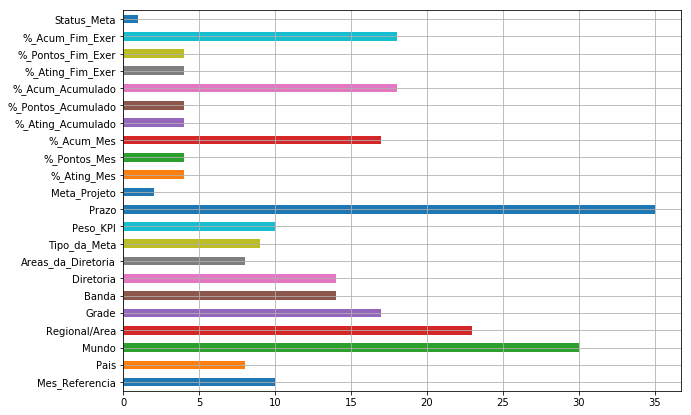

In [15]:
plt.figure(figsize=(10,7))
(df.loc[:, df.apply(lambda x: x.nunique()) < 50]).nunique().plot(kind='barh')
plt.grid()

### Categorias

Vejamos então a distribuição em algumas das principais categorias. Escolhemos aqui as que imaginamos serem mais intuitivas para iniciar a exploração. Para a maior parte dos gráficos nesta seção, temos a distribuição de funcionário no período inteiro; e alocação de funcionário por mês. Os dados sobre KPI serão analisados depois.

#### Mês

Olhando a distribuição na coluna `Mês Referência`, observamos que os dados se referem a Março de 2017 a Dezembro do mesmo ano, sugerindo o período de avaliação. Notamos ainda uma tendência de crescimento ao longo do ano, possivelmente pela adoção do sistema nos diversos setores da companhia.

Text(0.5, 0, 'Quantidade de pessoas alocadas')

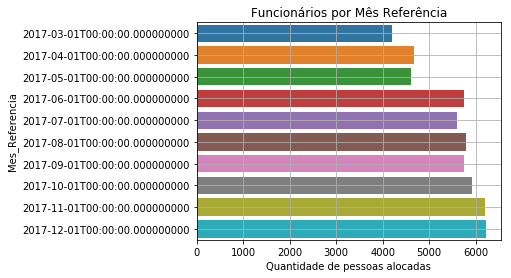

In [16]:
to_plot = 'Mes_Referencia'
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('Funcionários por Mês Referência')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario', to_plot]))

plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

#### País

Observando a coluna país, vemos que os dados passados se referem a atividades da companhia na América Latina, e que a grande maioria destas se concentra no Brasil. Investigando o Brasil dentro do conjunto de dados, observamos:
- Somente no Brasil 'Monitoramento Aprovado' foi utilizado em `Status_Meta`, assim como 'Sim' ou 'Nao' em `Meta_Projeto`
- O Brasil corresponde a todas `Regional/Area`, exceto pela 4, o que será importante futuramente
- O valor 'DG' em `Mundo` só foi utilizado no Brasil

Text(0.5, 0, 'Quantidade de pessoas alocadas')

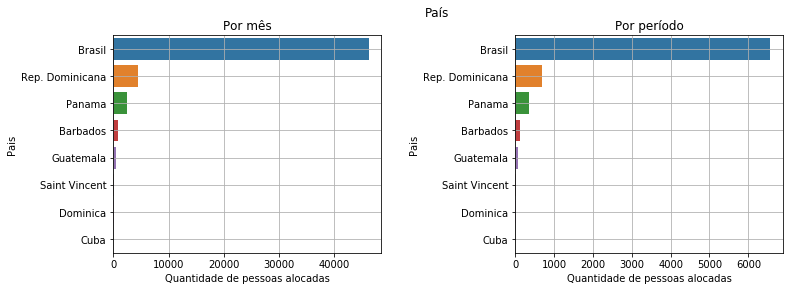

In [17]:
to_plot = 'Pais'
fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('País')

ax = fig.add_subplot(1, 2, 1)
ax.title.set_text('Por mês')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('Por período')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario', to_plot])[to_plot].value_counts().index)

plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

In [18]:
evaluate_col_val_df(df,'Pais','Brasil')

*** Mes_Referencia
* col == val only
{1488326400000000000, 1491004800000000000, 1493596800000000000}
* col != val only
set()

*** Pais
* col == val only
{'Brasil'}
* col != val only
{'Panama', 'Guatemala', 'Rep. Dominicana', 'Cuba', 'Dominica', 'Saint Vincent', 'Barbados'}

*** Mundo
* col == val only
{nan, 'DG'}
* col != val only
{'Comercial', 'Sales - Marketing', 'Asuntos Corporativos', 'Logistica', 'HILA - Suministros', 'Finance', 'Sales - Operaciones', 'Supply - Planta HN', 'Sales - Finanzas', 'People', 'Sales - Suministros', 'Sales - International', 'Sales - Legal', 'Marketing', 'Integracion', 'Sales - Cadena de Abastecimiento & TI', 'Sales - Gente y Gestion', 'Sales - Trade Marketing', 'Sales - Ventas', 'Solutions', 'Supply - Planta CND', 'Compras', 'Caribe Ex', 'Supply - Planta Habana', 'Sales - Proyectos y TI', 'HILA - Proceso de Ventas'}

*** Regional/Area
* col == val only
{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
* col != val only
{4}

*

#### Mundo

Analisando a coluna `Mundo`, percebemos que boa parte das atividades se concentra em 'Supply' e 'Sales'. Vemos ainda que algumas categorias não foram agrupadas por estarem com nomes se referindo a subdivisões, como por exemplo 'Sales - Ventas'. Vamos criar uma coluna agrupando estes valores, e analisar o mesmo gráfico.

Text(0.5, 0, 'Quantidade de pessoas alocadas')

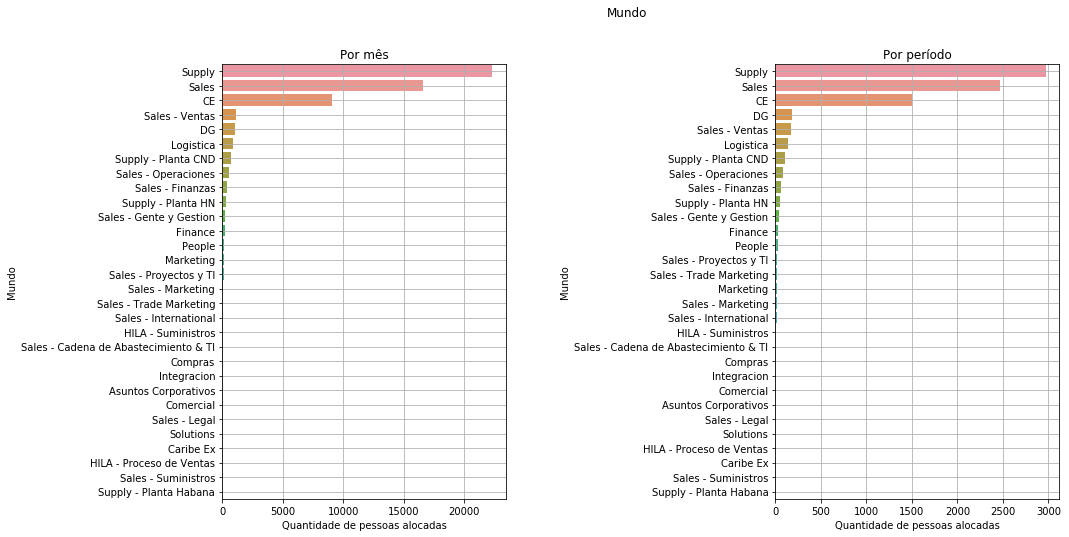

In [19]:
to_plot = 'Mundo'
fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(hspace=0.5, wspace=0.95)
fig.suptitle('Mundo')

ax = fig.add_subplot(1, 2, 1)
ax.title.set_text('Por mês')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('Por período')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario', to_plot])[to_plot].value_counts().index)

plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

In [20]:
df['Mundo_Agg'] = df['Mundo'].apply(lambda x : str(x).split(' - ')[0] if re.search(' - ',x) else x)

Text(0.5, 0, 'Quantidade de pessoas alocadas')

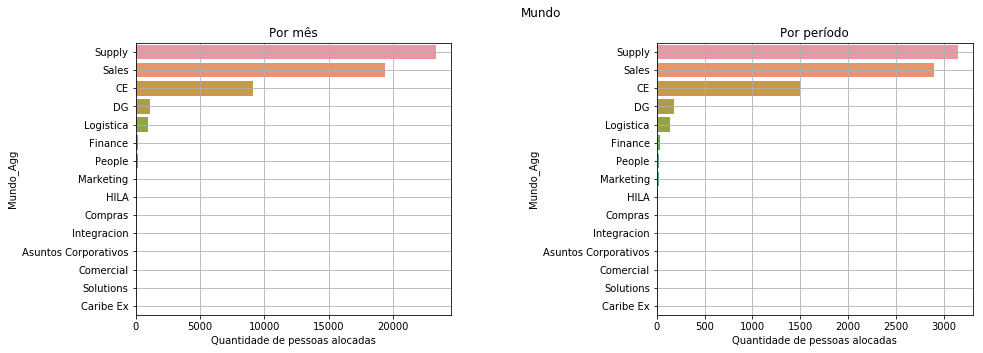

In [21]:
to_plot = 'Mundo_Agg'
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.65)
fig.suptitle('Mundo')

ax = fig.add_subplot(1, 2, 1)
ax.title.set_text('Por mês')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('Por período')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario', to_plot])[to_plot].value_counts().index)

plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

De fato, como podemos observar no gráfico da nova coluna, a vasta maioria dos funcionários está alocado em 'Sales' e 'Supply'.

#### Banda

A seguir avaliamos a distribuição por categoria em `Banda`.

Text(0.5, 0, 'Quantidade de pessoas alocadas')

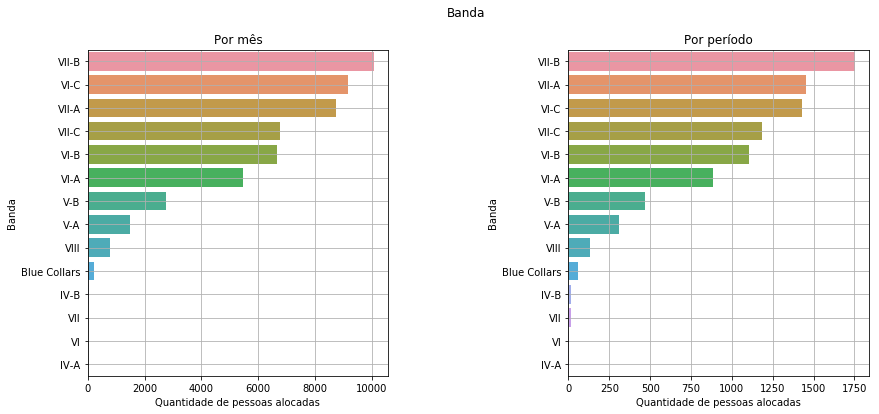

In [22]:
to_plot = 'Banda'
fig = plt.figure(figsize=(14,6))
fig.subplots_adjust(hspace=0.5, wspace=0.6)
fig.suptitle('Banda')

ax = fig.add_subplot(1, 2, 1)
ax.title.set_text('Por mês')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('Por período')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario', to_plot])[to_plot].value_counts().index)

plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')


#### Tipo da Meta

Observando a coluna `Tipo da Meta`, vemos que a maioria se concentra em 'Mandatório', seguido por 'Genérico'. Temos ainda alguns classificados como 'Metas Individuales'. Investigando estes casos, observamos que ocorrem somente na Regional 4.

Text(0.5, 0, 'Quantidade de pessoas alocadas')

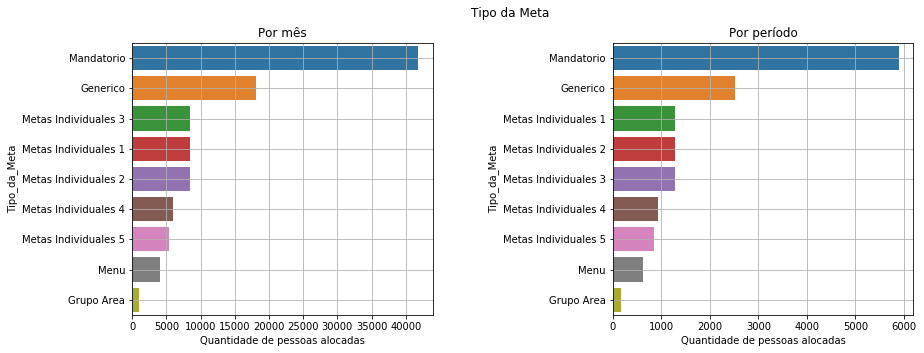

In [23]:
to_plot = 'Tipo_da_Meta'
fig = plt.figure(figsize=(14,5))
fig.subplots_adjust(hspace=0.5, wspace=0.6)
fig.suptitle('Tipo da Meta')

ax = fig.add_subplot(1, 2, 1)
ax.title.set_text('Por mês')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('Por período')
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario', to_plot])[to_plot].value_counts().index)

plt.grid()
plt.xlabel('Quantidade de pessoas alocadas')

In [24]:
evaluate_col_val_df(df,'Tipo_da_Meta','Metas Individuales 1')

*** Mes_Referencia
* col == val only
set()
* col != val only
{1488326400000000000, 1491004800000000000, 1493596800000000000}

*** Pais
* col == val only
set()
* col != val only
{'Brasil'}

*** Mundo
* col == val only
set()
* col != val only
{nan, 'DG'}

*** Regional/Area
* col == val only
set()
* col != val only
{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

*** Grade
* col == val only
{nan}
* col != val only
{nan, 17.0}

*** Banda
* col == val only
set()
* col != val only
{'VIII', 'IV-A'}

*** Diretoria
* col == val only
set()
* col != val only
{'Diretoria Disruptive Growth', 'F. Do Bem SP', 'Diretoria de Relacoes Corporativas', 'Diretoria de Suprimentos', 'Diretoria de Refrigenanc', 'Diretoria Logistica', 'Diretoria de Gente', 'Diretoria Industrial', 'Diretoria de Marketing', 'F. Do Bem RJ', 'Diretoria Tecnologia e Informacao', 'Diretoria Financeira', 'Diretoria Juridica', 'Diretoria de Vendas e Distribuicao'}

*** Areas_da_Diretoria
* col == val onl

In [25]:
evaluate_col_val_df(df,'Tipo_da_Meta','Mandatorio')

*** Mes_Referencia
* col == val only
set()
* col != val only
set()

*** Pais
* col == val only
set()
* col != val only
{'Panama', 'Guatemala', 'Rep. Dominicana', 'Cuba', 'Dominica', 'Saint Vincent', 'Barbados'}

*** Mundo
* col == val only
set()
* col != val only
{'Comercial', 'Sales - Marketing', 'Asuntos Corporativos', 'Logistica', 'HILA - Suministros', 'Finance', 'Sales - Operaciones', 'Supply - Planta HN', 'Sales - Finanzas', 'People', 'Sales - Suministros', 'Sales - International', 'Sales - Legal', 'Marketing', 'Integracion', 'Sales - Cadena de Abastecimiento & TI', 'Sales - Gente y Gestion', 'Sales - Trade Marketing', 'Sales - Ventas', 'Solutions', 'Supply - Planta CND', 'Compras', 'Caribe Ex', 'Supply - Planta Habana', 'Sales - Proyectos y TI', 'HILA - Proceso de Ventas'}

*** Regional/Area
* col == val only
{6}
* col != val only
{4}

*** Grade
* col == val only
{nan, 17.0}
* col != val only
{nan, 1.0, 2.0, 3.0, 4.0, 5.0}

*** Banda
* col == val only
{'IV-A'}
* col != val only
{

#### Status Meta

A seguir, podemos observar que o único valor de `Status_Meta`, 'Monitoramento Aprovado', só foi preenchido em pouco menos de 40% das entradas, isto é, mais de 60% dos valores da coluna não foram preenchidos.

Text(0.5, 0, 'Quantidade')

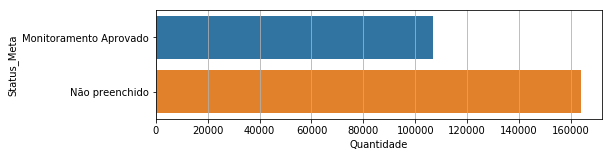

In [26]:
plt.figure(figsize=(8,2.0))
plt.grid()
meta_nan = 'Não preenchido'
df['Status_Meta'] = df['Status_Meta'].cat.add_categories(meta_nan)

sns.countplot(y=df['Status_Meta'].fillna(meta_nan))
plt.xlabel('Quantidade')

In [27]:
len(df[df['Status_Meta'].isna()])/len(df)*100

60.56947970129289

## Valores ausentes

Vamos observar então a distribuição de valores ausentes nas colunas, outra característica importante para entender os dados.

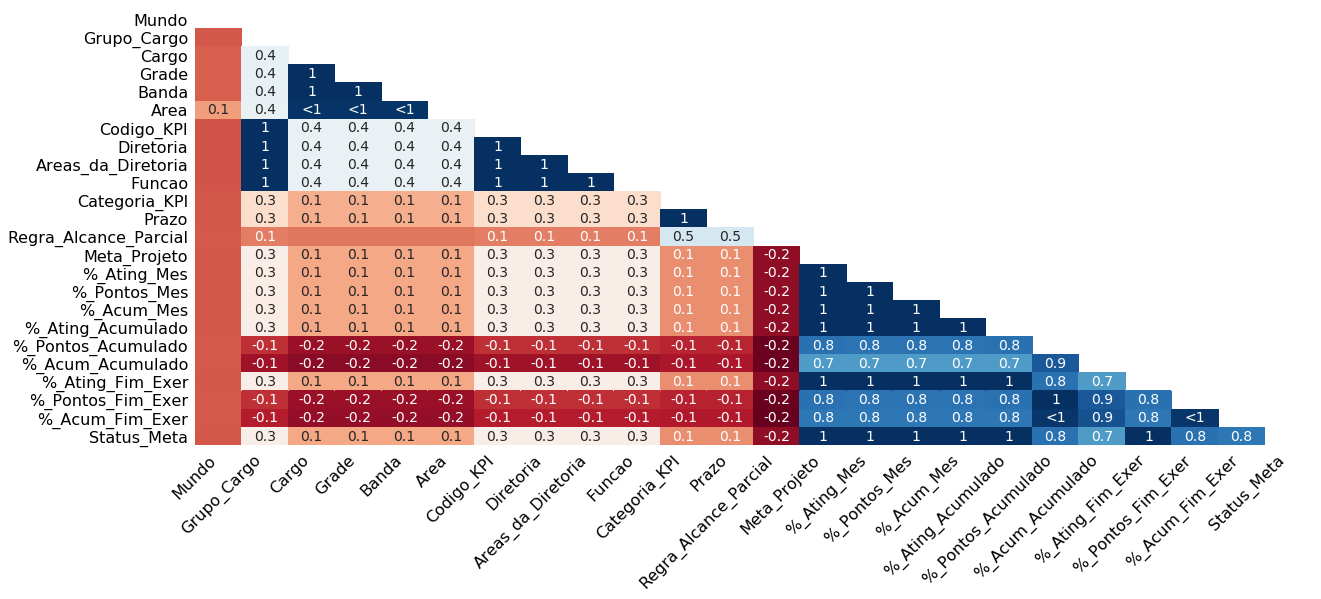

In [28]:
msno.heatmap(df,figsize=(20,8))

Além da alta correlação entre os valores não preenchidos nas categorias de porcentagem, notamos uma alta correlação entre estes com as colunas `Meta_Projeto` e `Status_Meta`, o que pode indicar:

- Uma inadequação de alguns setores com o sistema de monitoramento de metas; ou
- A ausência de necessidade de metas por serem áreas com objetivos pouco mensuráveis.

É importante discernir os casos, e que a companhia saiba destes, principalmente em se tratando do primeiro.

É possível notar ainda uma alta correlação entre os valores ausentes de `Grupo Cargo`, `Diretoria`, `Áreas da Diretoria` e `Código KPI`; e entre `Cargo`, `Grade`, `Área` e `Cargo`.

Vamos investigar essa features a seguir. 

### `Status Meta` e `Meta Projeto` 

Da análise das features `Status Meta` e `Meta Projeto`, podemos observar que os valores nulos se concentram na 'Regional/Area' de número 4. É importante que este fato seja conhecido, para que sejam tomadas as atitudes necessárias.

In [29]:
evaluate_missing_df(df,'Status_Meta')

*** Mes_Referencia
* NA only
set()
* Non-NA only
set()

*** Pais
* NA only
{'Panama', 'Guatemala', 'Rep. Dominicana', 'Cuba', 'Dominica', 'Saint Vincent', 'Barbados'}
* Non-NA only
set()

*** Mundo
* NA only
{'Comercial', 'Sales - Marketing', 'Asuntos Corporativos', 'Logistica', 'HILA - Suministros', 'Finance', 'Sales - Operaciones', 'Supply - Planta HN', 'Sales - Finanzas', 'People', 'Sales - Suministros', 'Sales - International', 'Sales - Legal', 'Marketing', 'Integracion', 'Sales - Cadena de Abastecimiento & TI', 'Sales - Gente y Gestion', 'Sales - Trade Marketing', 'Sales - Ventas', 'Solutions', 'Supply - Planta CND', 'Compras', 'Caribe Ex', 'Supply - Planta Habana', 'Sales - Proyectos y TI', 'HILA - Proceso de Ventas'}
* Non-NA only
set()

*** Regional/Area
* NA only
{4}
* Non-NA only
set()

*** Grade
* NA only
{nan, 1.0, 2.0, 3.0, 4.0, 5.0, 17.0}
* Non-NA only
{nan}

*** Banda
* NA only
{'VI', 'VII', 'Blue Collars', 'IV-A'}
* Non-NA only
set()

*** Diretoria
* NA only
{nan}
* Non

In [30]:
evaluate_missing_df(df,'Meta_Projeto')

*** Mes_Referencia
* NA only
set()
* Non-NA only
set()

*** Pais
* NA only
{'Panama', 'Guatemala', 'Rep. Dominicana', 'Cuba', 'Dominica', 'Saint Vincent', 'Barbados'}
* Non-NA only
set()

*** Mundo
* NA only
{'Comercial', 'Sales - Marketing', 'Asuntos Corporativos', 'Logistica', 'HILA - Suministros', 'Finance', 'Sales - Operaciones', 'Supply - Planta HN', 'Sales - Finanzas', 'People', 'Sales - Suministros', 'Sales - International', 'Sales - Legal', 'Marketing', 'Integracion', 'Sales - Cadena de Abastecimiento & TI', 'Sales - Gente y Gestion', 'Sales - Trade Marketing', 'Sales - Ventas', 'Solutions', 'Supply - Planta CND', 'Compras', 'Caribe Ex', 'Supply - Planta Habana', 'Sales - Proyectos y TI', 'HILA - Proceso de Ventas'}
* Non-NA only
set()

*** Regional/Area
* NA only
{4}
* Non-NA only
set()

*** Grade
* NA only
{nan, 1.0, 2.0, 3.0, 4.0, 5.0, 17.0}
* Non-NA only
{nan}

*** Banda
* NA only
{'VI', 'VII', 'Blue Collars', 'IV-A'}
* Non-NA only
set()

*** Diretoria
* NA only
{nan}
* Non

### `Categoria KPI`

Analisando as entradas que não possuem valores na feature `Categoria_KPI`, percebemos que todos se concentram também na 'Regional/Area' de número 4, além do fato de que nestes casos as colunas de porcentagens de pontos relacionadas a metas de KPI só possuem valores 0 ou não foram preenchidas.
Vejamos então as proporções com que cada Regional deixou de preencher dados de KPI.

In [31]:
for col in df.columns:
    print(col)
    print(df[df['Categoria_KPI'].isna()][col].unique())

Mes_Referencia
['2017-06-01T00:00:00.000000000' '2017-07-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2017-09-01T00:00:00.000000000'
 '2017-10-01T00:00:00.000000000' '2017-11-01T00:00:00.000000000'
 '2017-12-01T00:00:00.000000000']
Pais
[Barbados, Cuba, Dominica, Guatemala, Panama, Rep. Dominicana]
Categories (6, object): [Barbados, Cuba, Dominica, Guatemala, Panama, Rep. Dominicana]
Mundo
[Supply, Sales, Finance, Integracion, Marketing, ..., Sales - Proyectos y TI, Sales - Suministros, Sales - Trade Marketing, Supply - Planta CND, Asuntos Corporativos]
Length: 24
Categories (24, object): [Supply, Sales, Finance, Integracion, ..., Sales - Suministros, Sales - Trade Marketing, Supply - Planta CND, Asuntos Corporativos]
Regional/Area
[4]
Unidade
[ 16  17 257 279 264 258 305 306 315 328 329  47  50  56  69 113 147 159
 160 161 165 265 290 292 312 325 316]
Grupo_Cargo
[NaN]
Categories (0, object): []
Cargo
[NaN, GER DE TRADE MKTG ROTA III, COORDENADOR JR, ANALISTA II, ESPECIALI

Text(0, 0.5, 'Regional/Area')

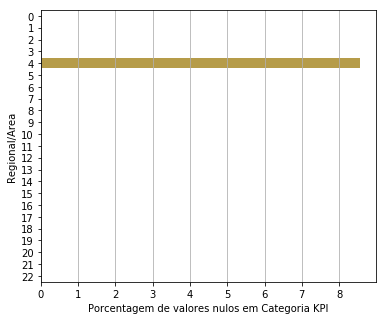

In [32]:
vals = []
for a in sorted(df['Regional/Area'].unique()):
    vals.append([a,100*len(df[df['Categoria_KPI'].isna() & (df['Regional/Area']==a)])/len(df[(df['Regional/Area']==a)])])
    
plt.figure(figsize=(6,5))
plt.grid()
sns.barplot(y=[i[0] for i in vals], x=[i[1] for i in vals], orient="h")
plt.xlabel("Porcentagem de valores nulos em Categoria KPI")
plt.ylabel("Regional/Area")

A partir do gráfico, vemos que todas Áreas preencheram integralmente os valores de Categoria de KPI, exceto pela 4. Esta deixou de fazê-lo em pouco mais de 8% das entradas fornecidas.

Analisamos então a proporção com que a mesma área deixou de incluir dados em algumas colunas. Além das já discutidas, vale notar que `Cargo` e `Grade` não foram preenchidas em cerca de 20% dos casos.

Text(0, 0.5, 'Coluna')

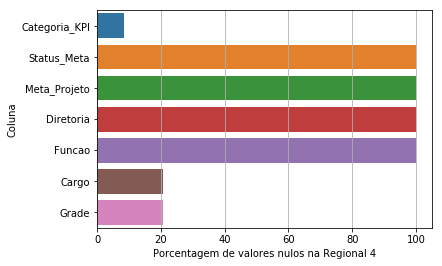

In [33]:
vals = []
for a in ['Categoria_KPI','Status_Meta','Meta_Projeto', 'Diretoria', 'Funcao', 'Cargo', 'Grade']:
    vals.append([a,100*len(df[df[a].isna() & (df['Regional/Area']==4)])/len(df[(df['Regional/Area']==4)])])
    
plt.figure(figsize=(6,4))
plt.grid()
sns.barplot(y=[i[0] for i in vals], x=[i[1] for i in vals], orient="h")
plt.xlabel("Porcentagem de valores nulos na Regional 4")
plt.ylabel("Coluna")

## KPI

Vamos então analisar mais a fundo os dados de KPI.

### Principais categorias

Vamos analisar aqui as principais categorias de KPI no dataframe. Do gráfico, vemos que boa parte se concentra em 'Melhoria Contínua', seguido por 'Rentabilidade/Custos' e 'Market Share/Volume'. As 10 principais categorias serão armazenadas para análise futura.

In [34]:
# Operações a serem realizadas
oper = ['mean', 'std']

# Colunas a serem agrupadas
kpi_cols = {'Peso_KPI' : oper + ['count']} 
for col in df.columns:
    if re.search('^%_',col):
        kpi_cols[col] = oper

Text(0.5, 1.0, 'Quantidade de Funcionários por Período')

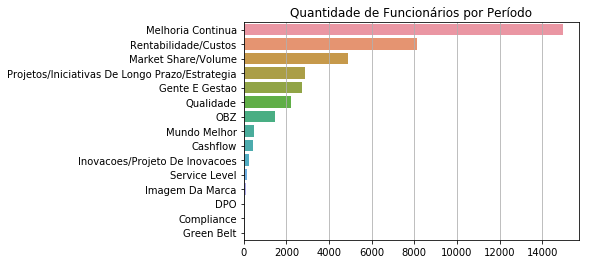

In [35]:
# Criamos então o dataframe agregando as features por categoria        
agg_df = df[~df['Categoria_KPI'].isna()].\
        drop_duplicates(['Nome_Funcionario', 'Codigo_KPI']).groupby('Categoria_KPI').\
                        agg(kpi_cols)
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]

plt.grid()
sns.barplot(x=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].values.tolist(), 
            y=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].index.values.tolist())
plt.title('Quantidade de Funcionários por Período')

Text(0.5, 1.0, 'Quantidade de Funcionários por Mês')

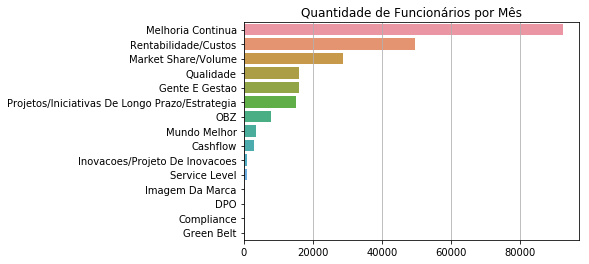

In [36]:
# Criamos outro dataframe, agregando as features por categoria, mas considerando também os meses    
agg_df = df[~df['Categoria_KPI'].isna()].\
        drop_duplicates(['Nome_Funcionario', 'Mes_Referencia', 'Codigo_KPI']).groupby('Categoria_KPI').\
                        agg(kpi_cols)
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]

plt.grid()
sns.barplot(x=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].values.tolist(), 
            y=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].index.values.tolist())

plt.title('Quantidade de Funcionários por Mês')

In [37]:
main_kpi_cats = agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'].index.tolist()[:10]

### Porcentagens

Vamos analisar então as relações e as distribuições das categorias de porcentagem (iniciando com '%'). Entendemos que estas se referem a pontuação no KPI e, portanto, são de grande importância.

A partir de observação dos dados fornecidos, concluímos:
- `Pontos` menor ou igual que `Ating`
- `Pontos` * `Peso_KPI`/100 = `Acum`

In [38]:
for period in ['Mes', 'Acumulado', 'Fim_Exer']:
    print(period)
    print('Relação 1: ' + str(df[df['%_Ating_' + period] < df['%_Pontos_' + period]].shape[0]))
    print('Relação 2: ' + str(df[df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period]].shape[0]))
    print('Relação 2 (Pontos não-nulo): ' + str(df[~df['%_Pontos_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print('Relação 2 (Acum não-nulo): ' + str(df[~df['%_Acum_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print('Relação 2 (Ambos não-nulos): ' + str(df[~df['%_Acum_'+period].isna() & ~df['%_Pontos_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print('Relação 2 (Ambos nulos): ' + str(df[df['%_Acum_'+period].isna() & df['%_Pontos_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print()

Mes
Relação 1: 0
Relação 2: 164348
Relação 2 (Pontos não-nulo): 0
Relação 2 (Acum não-nulo): 0
Relação 2 (Ambos não-nulos): 0
Relação 2 (Ambos nulos): 164348

Acumulado
Relação 1: 0
Relação 2: 152169
Relação 2 (Pontos não-nulo): 10933
Relação 2 (Acum não-nulo): 2189
Relação 2 (Ambos não-nulos): 0
Relação 2 (Ambos nulos): 139047

Fim_Exer
Relação 1: 0
Relação 2: 141215
Relação 2 (Pontos não-nulo): 0
Relação 2 (Acum não-nulo): 2168
Relação 2 (Ambos não-nulos): 0
Relação 2 (Ambos nulos): 139047



Note que a segunda observação não vale para todos valores de entrada, mas devido à presença de valores nulos. Usando a regra inferida, vamos recuperar estes valores.

In [39]:
for period in ['Acumulado','Fim_Exer']:
    # Recuperar Acum a partir de Pontos
    mask = (~df['%_Pontos_' + period].isna() & df['%_Acum_'+period].isna())
    df_valid = df[mask]

    df.loc[mask, '%_Acum_'+period] = (df_valid['%_Pontos_'+period] * df_valid['Peso_KPI'] * 0.01)
    
    # Recuperar Pontos a partir de Acum
    mask = (df['%_Pontos_' + period].isna() & ~df['%_Acum_'+period].isna() & (df['Peso_KPI']!=0))
    df_valid = df[mask]

    df.loc[mask, '%_Pontos_'+period] = (100* df_valid['%_Acum_'+period] / df_valid['Peso_KPI'])
    
    # Recuperar Pontos a partir de Acum, caso em que Peso_KPI é zero
    mask = (df['%_Pontos_' + period].isna() & ~df['%_Acum_'+period].isna() & (df['Peso_KPI']==0))

    df.loc[mask, '%_Pontos_'+period] = 0

In [40]:
for period in ['Mes', 'Acumulado', 'Fim_Exer']:
    print(period)
    print('Relação 1: ' + str(df[df['%_Ating_' + period] < df['%_Pontos_' + period]].shape[0]))
    print('Relação 2: ' + str(df[df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period]].shape[0]))
    print('Relação 2 (Pontos não-nulo): ' + str(df[~df['%_Pontos_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print('Relação 2 (Acum não-nulo): ' + str(df[~df['%_Acum_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print('Relação 2 (Ambos não-nulos): ' + str(df[~df['%_Acum_'+period].isna() & ~df['%_Pontos_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print('Relação 2 (Ambos nulos): ' + str(df[df['%_Acum_'+period].isna() & df['%_Pontos_'+period].isna() &
        (df['%_Pontos_'+period]*df['Peso_KPI']/100!=df['%_Acum_'+period])].shape[0]))
    print()

Mes
Relação 1: 0
Relação 2: 164348
Relação 2 (Pontos não-nulo): 0
Relação 2 (Acum não-nulo): 0
Relação 2 (Ambos não-nulos): 0
Relação 2 (Ambos nulos): 164348

Acumulado
Relação 1: 0
Relação 2: 139047
Relação 2 (Pontos não-nulo): 0
Relação 2 (Acum não-nulo): 0
Relação 2 (Ambos não-nulos): 0
Relação 2 (Ambos nulos): 139047

Fim_Exer
Relação 1: 0
Relação 2: 139047
Relação 2 (Pontos não-nulo): 0
Relação 2 (Acum não-nulo): 0
Relação 2 (Ambos não-nulos): 0
Relação 2 (Ambos nulos): 139047



Vemos agora que as duas relações batem, exceto para os casos em que 'Pontos' e 'Acum' são nulos. 

Vejamos as distribuições comparadas de categorias de porcentagem e `Peso_KPI`.

/anaconda2/envs/challenge/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda2/envs/challenge/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


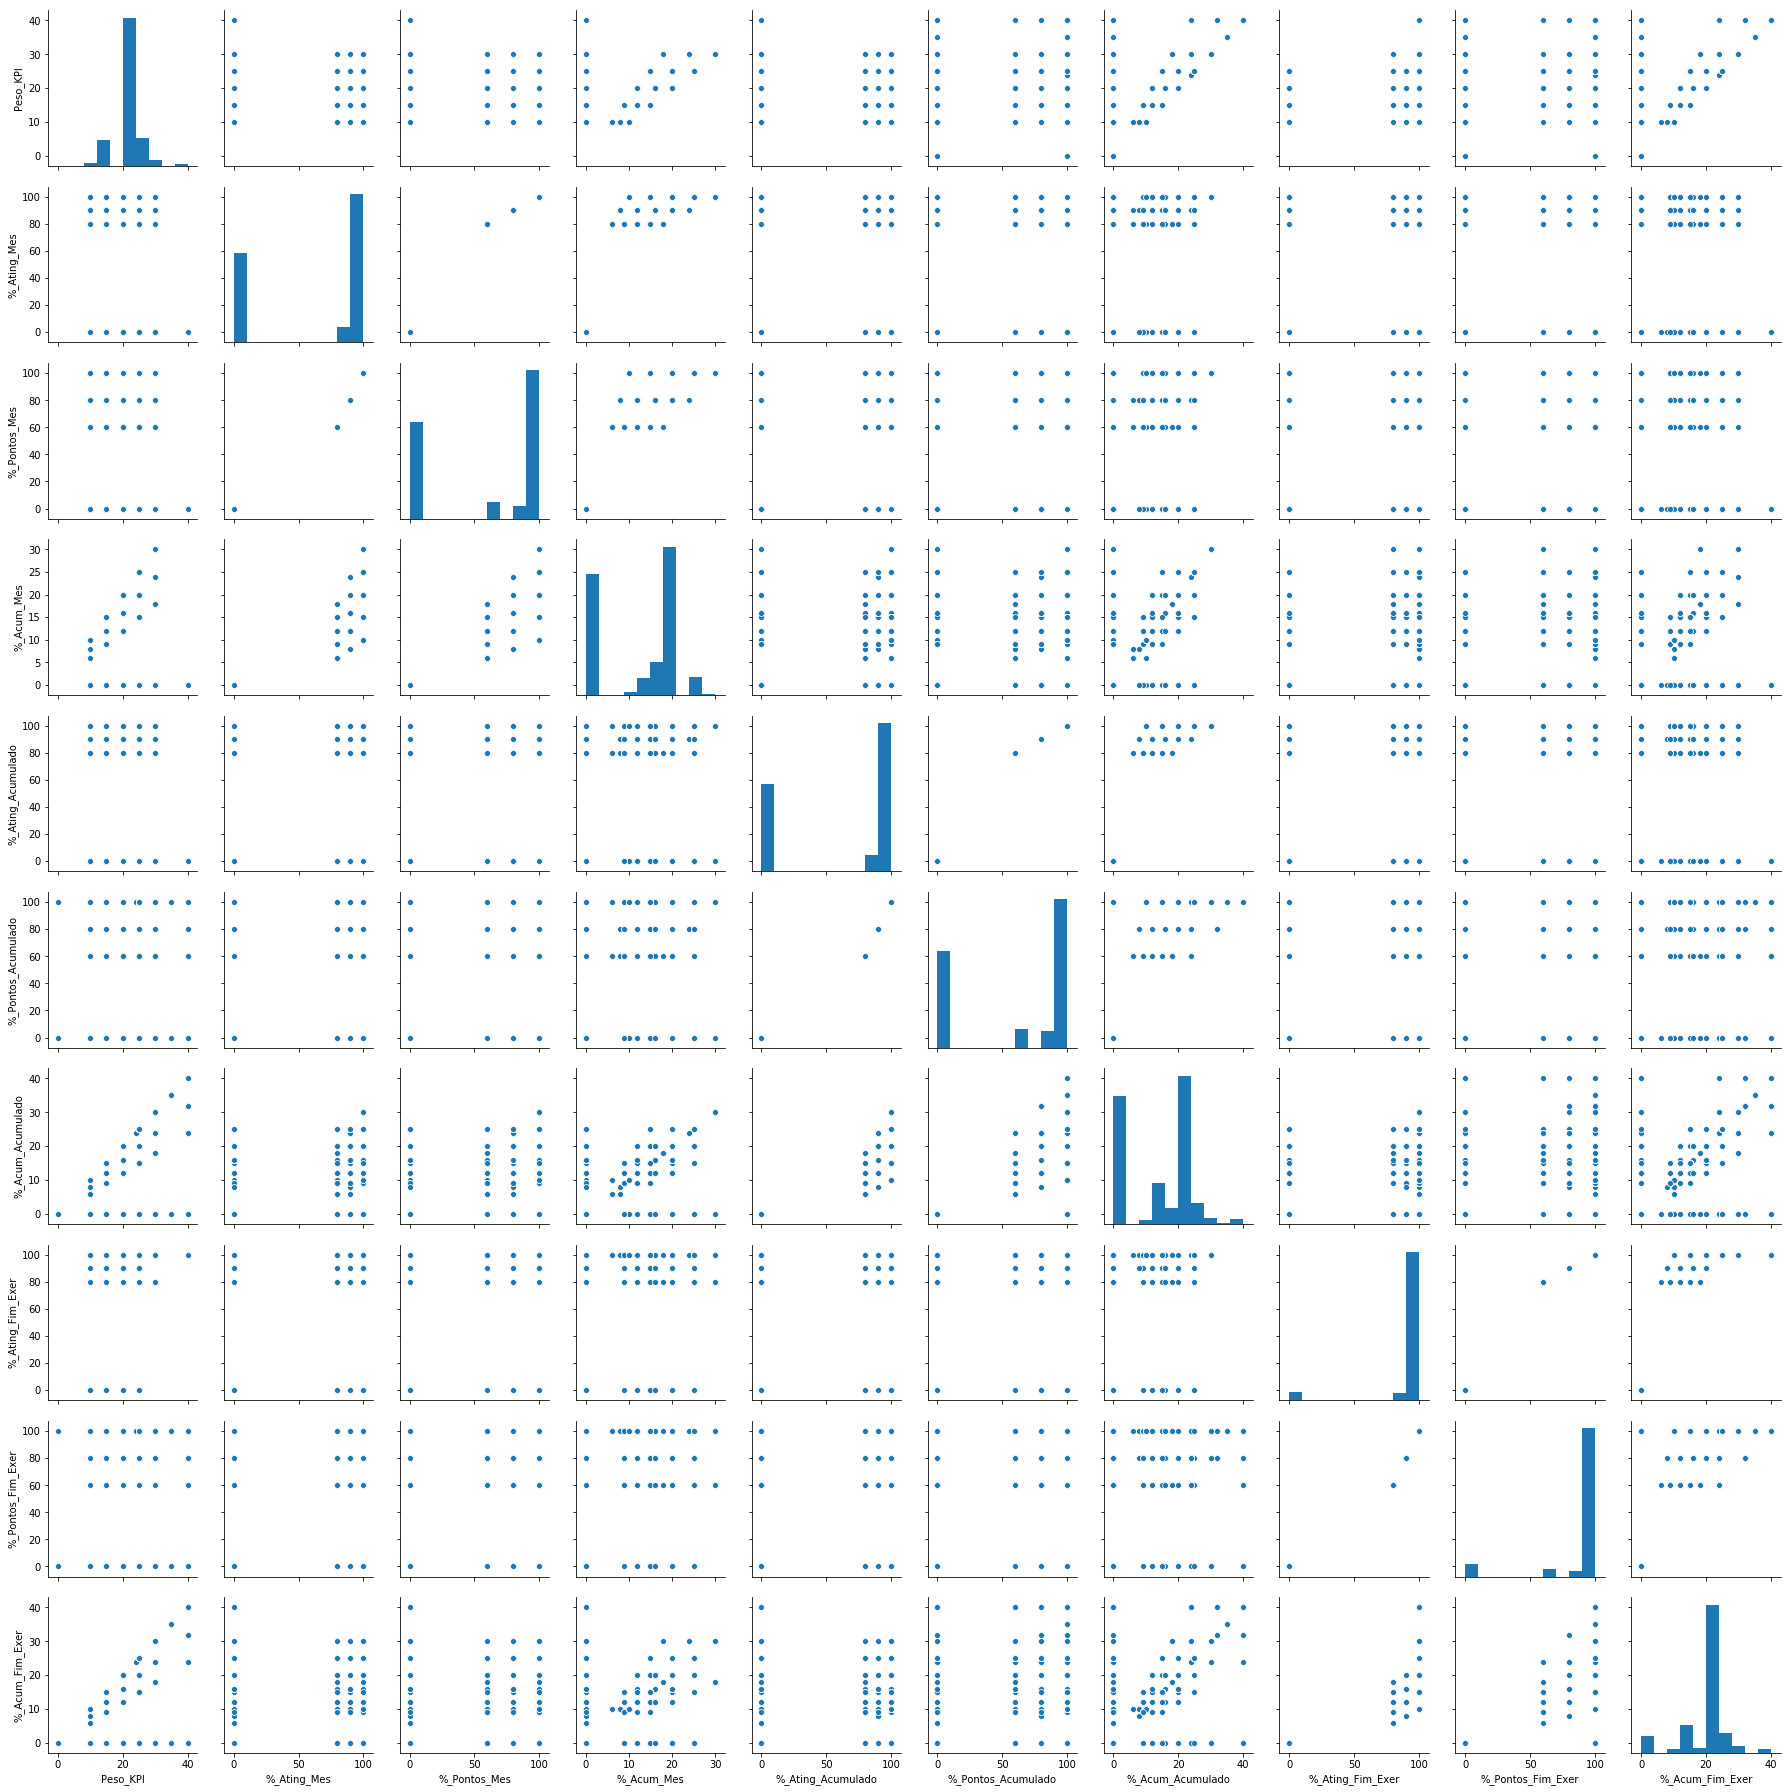

In [41]:
sns.pairplot(df[df['Categoria_KPI'].isin(main_kpi_cats)].\
        drop_duplicates(['Nome_Funcionario', 'Categoria_KPI'])[list(kpi_cols.keys())]);

Do gráfico acima, podemos observar:
- `Peso_KPI` e `%_Acum_Fim_Exer` seguem uma distribuição próxima de normal
- Todas as colunas com `Ating` ou `Pontos` no ínicio possuem maior concentração nos valores 0 ou 100, sendo que aquelas com final `Fim_Exer` possui quase todos os valores em 100
- As colunas iniciando com `Acum` parecem ter uma relação (próxima de) linear com `Peso_KPI`
- As colunas iniciando com `Acum` parecem estar correlacionadas entre si, sendo esta correlação menor para `%_Acum_Fim_Exer`

Alguns destes fatos podem ser observados no mapa de correlação a seguir.

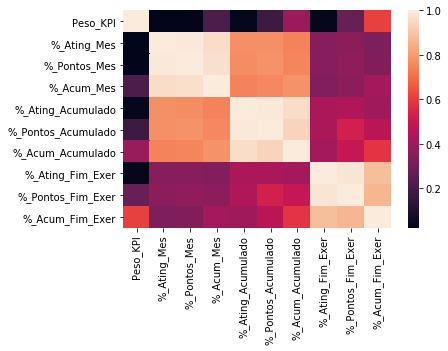

In [42]:
corr = df[list(kpi_cols.keys())].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Text(0, 0.5, 'Pontos')

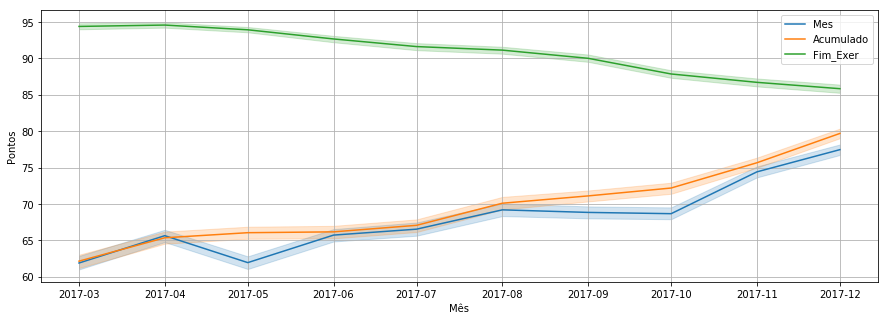

In [65]:
plt.figure(figsize=(15,5))
sns.lineplot(x="Mes_Referencia", y="%_Pontos_Mes",
            data=df[~df['%_Pontos_Mes'].isna() & ~df['%_Pontos_Acumulado'].isna() & ~df['%_Pontos_Fim_Exer'].isna()],           
            label='Mes')

sns.lineplot(x="Mes_Referencia", y="%_Pontos_Acumulado",
             data=df[~df['%_Pontos_Mes'].isna() & ~df['%_Pontos_Acumulado'].isna() & ~df['%_Pontos_Fim_Exer'].isna()],
             label='Acumulado'
            )


sns.lineplot(x="Mes_Referencia", y="%_Pontos_Fim_Exer",
             data=df[~df['%_Pontos_Mes'].isna() & ~df['%_Pontos_Acumulado'].isna() & ~df['%_Pontos_Fim_Exer'].isna()],
             label='Fim_Exer'
            )


plt.grid()
plt.xlabel('Mês')
plt.ylabel('Pontos')

### Peso KPI

Analisamos agora os pesos dados às metas no KPI. Primeiramente, vamos analisar como `Peso_KPI` varia ao longo do ano. Vemos a seguir que os valores flutuam um pouco, mas permanecem sempre próximos do valor 20. Vamos analisar então como eles variam em diferentes categorias.

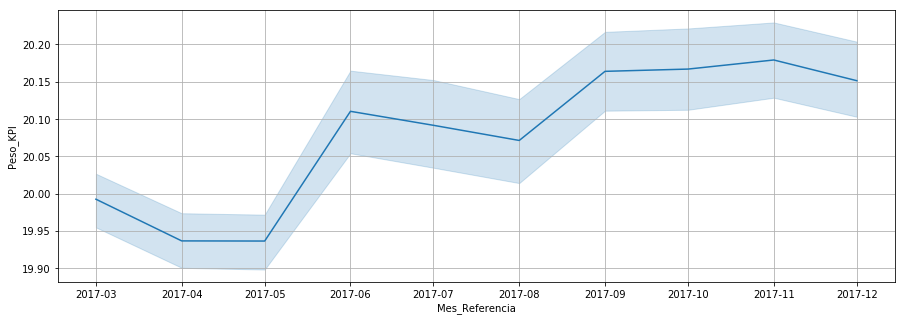

In [48]:
plt.figure(figsize=(15,5))
plt.grid()
sns.lineplot(x="Mes_Referencia", 
             y="Peso_KPI",
             data=df)

Vemos a seguir os pesos separados por país. Nota-se que para o Brasil eles permanecem estáveis, na linha de 20, começando em Março. Para os outros países, estes valores iniciam em Junho somente, indicando uma adoção tardia. Notamos ainda que Panamá tem a maior faixa de valores, e Cuba a menor.

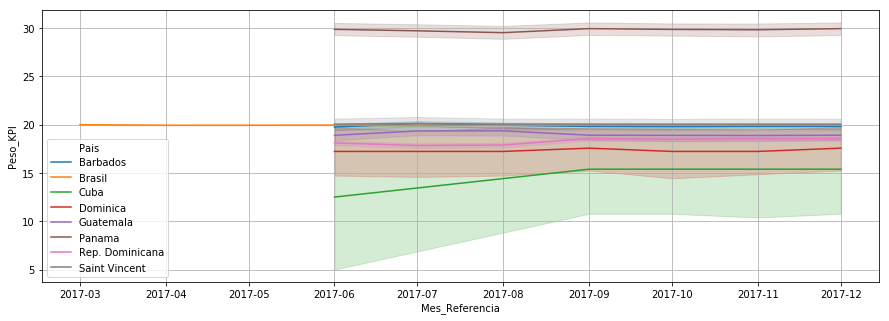

In [49]:
plt.figure(figsize=(15,5))
plt.grid()
sns.lineplot(x="Mes_Referencia", 
             y="Peso_KPI",
             hue="Pais",
             data=df)

Analisando os valores para as duas maiores categorias de `Mundo`, percebemos que eles são estáveis até Maio. A partir de Junho, quando ocorre a adoção em outros países da América Latina, os pesos para 'Supply' aumentam, enquanto diminuem para 'Sales'.

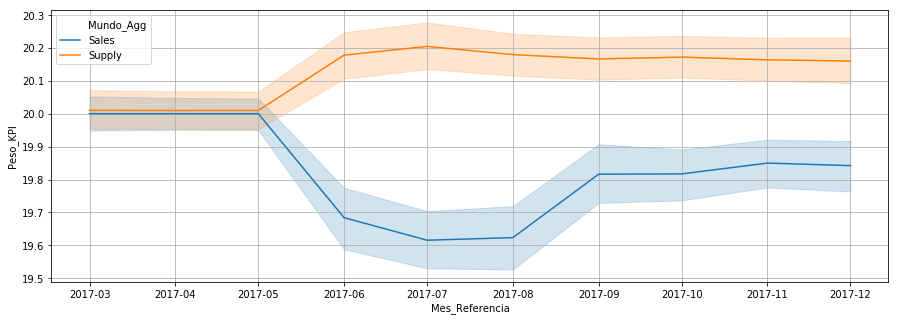

In [50]:
plt.figure(figsize=(15,5))
plt.grid()
sns.lineplot(x="Mes_Referencia", 
             y="Peso_KPI",
             hue="Mundo_Agg",
             #data=df[df['Mundo_Agg'].isin(['Sales', 'Supply'])]
             data=df[df['Mundo_Agg'].isin(['Sales', 'Supply'])]
            )

Analisamos então os valores para as principais categorias de KPI. Todos as categorias permanecem estáveis ao longo do ano, exceto por duas: 'Mundo Melhor' tem um aumento a partir de Junho, o que pode indicar uma priorização, a nível de empresa, nesse sentido; e 'Cashflow', que tem algumas flutuações mais bruscas, mas permanecendo a menor faixa de valores.

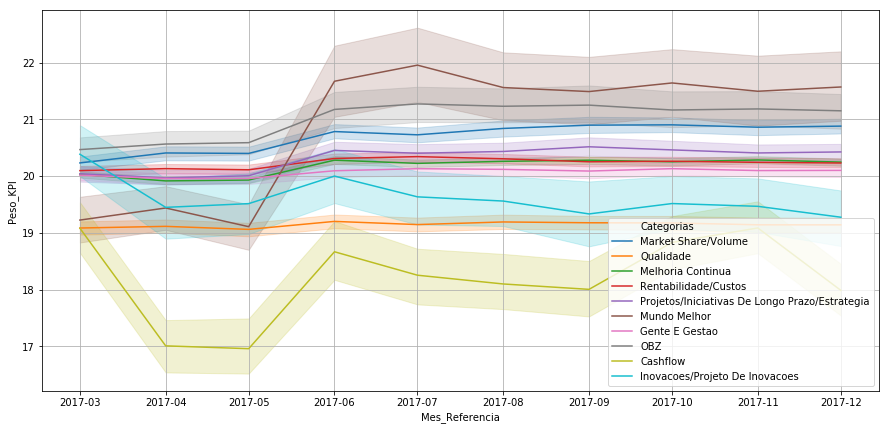

In [51]:
df['Categorias'] = df['Categoria_KPI'].apply(lambda x : x if x in main_kpi_cats else pd.np.nan)
plt.figure(figsize=(15,7))
plt.grid()
sns.lineplot(x="Mes_Referencia", 
             y="Peso_KPI",
             hue="Categorias",
             data=df[~df['Categorias'].isna()])
plt.legend()

### Metas cumpridas

Baseado nas avaliações anteriores, vamos analisar a porcentagem de metas cumpridas. Consideraremos uma meta como cumprida quando o valor de `Pontos` for igual a `Ating`, uma vez que vimos que `Ating` é sempre maior ou igual a `Pontos`, isto é, `Ating` parece ser o valor de pontos a ser atingido.

In [43]:
for period in ['Mes', 'Acumulado', 'Fim_Exer']:
    print(period + ': ' + "{0:.2f}".format((df[df['%_Ating_'+period] == df['%_Pontos_'+period]].\
                               drop_duplicates(['Nome_Funcionario','Mes_Referencia','Codigo_KPI']).shape[0]\
           /df.drop_duplicates(['Nome_Funcionario','Mes_Referencia','Codigo_KPI']).shape[0])*100) + '%')

Mes: 39.19%
Acumulado: 38.61%
Fim_Exer: 40.25%


Text(0, 0.5, 'Período')

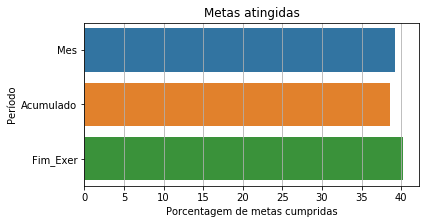

In [44]:
vals = []
for period in ['Mes', 'Acumulado', 'Fim_Exer']:
    vals.append([period,(df[df['%_Ating_'+period] == df['%_Pontos_'+period]].\
                               drop_duplicates(['Nome_Funcionario','Mes_Referencia','Codigo_KPI']).shape[0]\
                            /df.drop_duplicates(['Nome_Funcionario','Mes_Referencia','Codigo_KPI']).shape[0])*100])
    
plt.figure(figsize=(6,3))
plt.grid()
sns.barplot(y=[i[0] for i in vals], x=[i[1] for i in vals], orient="h")
plt.title('Metas atingidas')
plt.xlabel("Porcentagem de metas cumpridas")
plt.ylabel("Período")

Vemos que os valores de metas cumpridas, considerando Funcionário por Mês por Meta, giram em torno de 40%, nos 3 casos. Contudo, isto se deve ao grande número de entradas nulas nas colunas. No caso em que as colunas são preenchidas e comparáveis, estas porcentagens são próximas de 90%.

In [45]:
for period in ['Mes', 'Acumulado', 'Fim_Exer']:
    print(period + ': ' + "{0:.2f}".format((df[df['%_Ating_'+period] == df['%_Pontos_'+period]].\
                               drop_duplicates(['Nome_Funcionario','Mes_Referencia','Codigo_KPI']).shape[0]\
           /df[df['%_Ating_'+period] >= df['%_Pontos_'+period]].\
                    drop_duplicates(['Nome_Funcionario','Mes_Referencia','Codigo_KPI']).shape[0])*100) + '%')

Mes: 88.25%
Acumulado: 86.61%
Fim_Exer: 90.29%


Text(0, 0.5, 'Período')

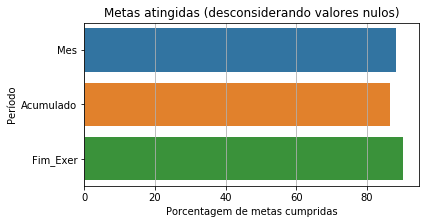

In [46]:
vals = []
for period in ['Mes', 'Acumulado', 'Fim_Exer']:
    vals.append([period,(df[df['%_Ating_'+period] == df['%_Pontos_'+period]].\
                               drop_duplicates(['Nome_Funcionario','Mes_Referencia','Codigo_KPI']).shape[0]\
                            /df[df['%_Ating_'+period] >= df['%_Pontos_'+period]].drop_duplicates(['Nome_Funcionario','Mes_Referencia','Codigo_KPI']).shape[0])*100])
    
plt.figure(figsize=(6,3))
plt.grid()
sns.barplot(y=[i[0] for i in vals], x=[i[1] for i in vals], orient="h")
plt.title('Metas atingidas (desconsiderando valores nulos)')
plt.xlabel("Porcentagem de metas cumpridas")
plt.ylabel("Período")

Daqui podemos notar: há uma grande quantidade de valores nulos nestes dados; e houve um bom índice de cumprimento das metas dentre aqueles que as adotaram e preencheram.

Vamos criar a seguir 3 novas colunas, binárias, para indicar o cumprimento da meta em cada caso.

In [47]:
for period in ['Mes', 'Acumulado', 'Fim_Exer']:
    df['target'+period] = df.apply(lambda row: 1 if (row['%_Ating_'+period] == row['%_Pontos_'+period]) else 0, axis=1)

Vamos analisar o cumprimento das metas por categorias. A partir do gráfico, vemos que somente no Brasil foram cumpridas metas. Para os outros países, o número de metas cumpridas é nulo ou zero.

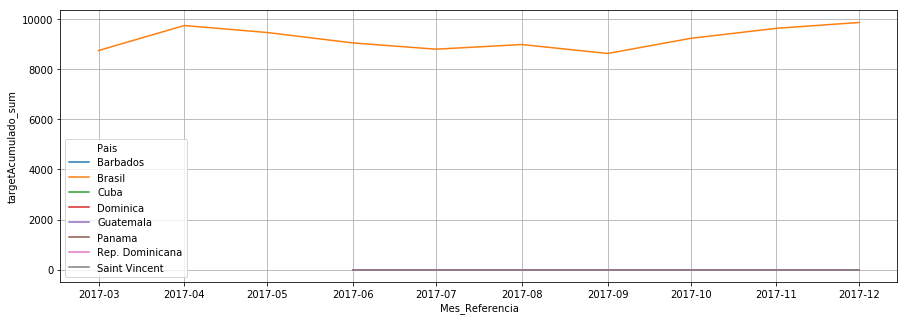

In [67]:
kpi_mes_df = df.groupby(['Mes_Referencia','Pais']).agg({
    'targetMes':['sum'],
    'targetAcumulado':['sum'],
    'targetFim_Exer':['sum']
})
kpi_mes_df.columns = ['_'.join(col).strip() for col in kpi_mes_df.columns.values]
kpi_mes_df.reset_index(inplace=True)

plt.figure(figsize=(15,5))
plt.grid()
sns.lineplot(x="Mes_Referencia", 
             y="targetAcumulado_sum",
             hue="Pais",
             #data=kpi_mes_df[kpi_mes_df['Pais'].isin(['Sales', 'Supply'])]
            data=kpi_mes_df
            )

Analisamos ainda os principais setores em `Mundo`: 'Sales' tem alta nos meses de Abril e Maio, e então cai até chegar no valor mais baixo em Setembro; já 'Supply' se mantém relativamente estável, com queda nos meses de Junho e Julho.

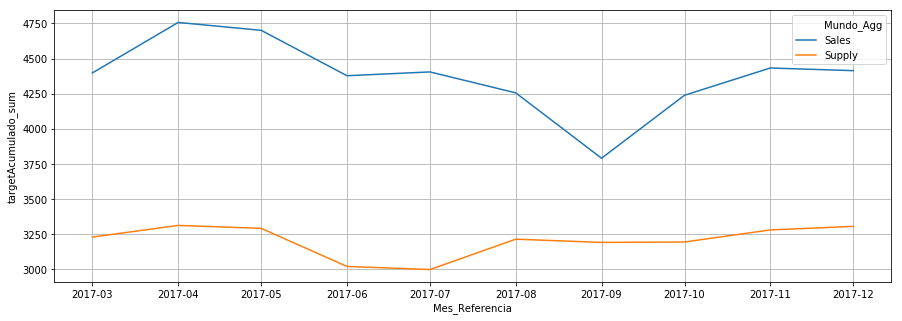

In [69]:
kpi_mes_df = df.groupby(['Mes_Referencia','Mundo_Agg']).agg({
    'targetMes':['sum'],
    'targetAcumulado':['sum'],
    'targetFim_Exer':['sum']
})
kpi_mes_df.columns = ['_'.join(col).strip() for col in kpi_mes_df.columns.values]
kpi_mes_df.reset_index(inplace=True)

plt.figure(figsize=(15,5))
plt.grid()
sns.lineplot(x="Mes_Referencia", 
             y="targetAcumulado_sum",
             hue="Mundo_Agg",
             data=kpi_mes_df[kpi_mes_df['Mundo_Agg'].isin(['Sales', 'Supply'])]
            #data=kpi_mes_df
            )

In [98]:
kpi_agg = df.groupby(['Nome_Funcionario', 'Mes_Referencia', 'Pais']).\
            agg({
            'targetMes':['mean'],
            'targetAcumulado':['mean'],
            'targetFim_Exer':['mean']
})

kpi_agg.columns = ['_'.join(col).strip() for col in kpi_agg.columns.values]
kpi_agg.reset_index(inplace=True)

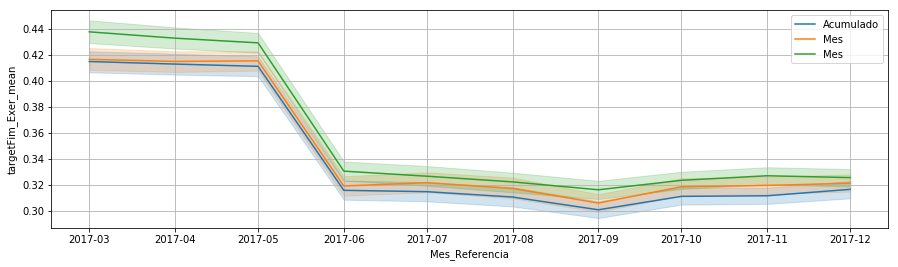

In [82]:
plt.figure(figsize=(15,4))
sns.lineplot(x="Mes_Referencia", 
             y="targetAcumulado_mean",
            data=kpi_agg,
             label='Acumulado'
            )
sns.lineplot(x="Mes_Referencia", 
             y="targetMes_mean",
            data=kpi_agg,
             label='Mes'
            )

sns.lineplot(x="Mes_Referencia", 
             y="targetFim_Exer_mean",
            data=kpi_agg,
             label='Mes'
            )
plt.grid()

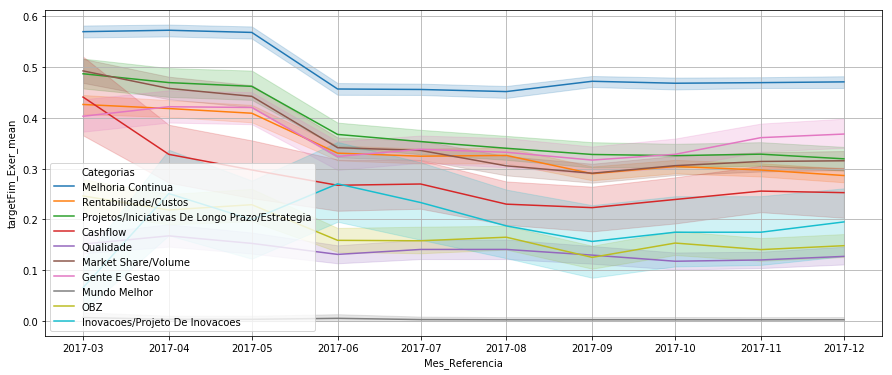

In [92]:
plt.figure(figsize=(15,6))
sns.lineplot(x="Mes_Referencia", 
             y="targetFim_Exer_mean",
             hue="Categorias",
             data=kpi_agg[~kpi_agg['Categorias'].isna()])
plt.legend()
plt.grid()

# Modelo

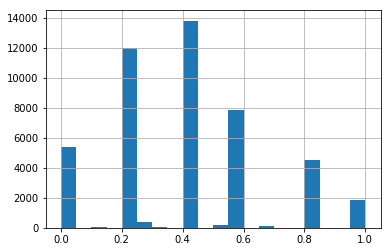

In [100]:
kpi_agg[kpi_agg['Pais']=='Brasil']['targetAcumulado_mean'].hist(bins=20)